In [1]:
import os
import shutil
import tarfile
import numpy as np
import librosa
import librosa.feature
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import time
import sys

In [2]:
EXTRACT_PATH = '/home/aljaz/Desktop/workspace/FERI/magisterij/ROSIS/09_remove_noise/datasets/librispeech/LibriSpeech/dev-clean'
DATA_DIR = './data'
MAX_AUDIO_LEN_S = 10.0
SEGMENT_LEN_S = 2.0
SAMPLE_RATE = 16000
N_MFCC = 40
N_FFT = 2048
HOP_LENGTH = 512

In [3]:
def analyze_dataset():
    if not os.path.exists(EXTRACT_PATH):
        print(f"Folder {EXTRACT_PATH} does not exists")
        return

    speaker_dirs = [d for d in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, d))]

    speaker_stats = {}
    total_files = 0

    for speaker_id in speaker_dirs:
        speaker_path = os.path.join(EXTRACT_PATH, speaker_id)
        for root, _, files in os.walk(speaker_path):
            flac_files = [f for f in files if f.endswith(".flac")]
            if speaker_id not in speaker_stats:
                speaker_stats[speaker_id] = {'count': 0, 'durations': []}

            speaker_stats[speaker_id]['count'] += len(flac_files)
            total_files += len(flac_files)

            for f in flac_files:
                file_path = os.path.join(root, f)
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                speaker_stats[speaker_id]['durations'].append(librosa.get_duration(y=y, sr=sr))

    num_speakers = len(speaker_stats)

    file_counts = [s['count'] for s in speaker_stats.values()]
    all_durations = [d for s in speaker_stats.values() for d in s['durations']]

    print("--- Analiza Podatkovne Zbirke ---")
    print(f"Število govorcev: {num_speakers}")
    print(f"Število vseh posnetkov: {total_files}")
    print("\nStatistika števila posnetkov na govorca:")
    print(f"  - Povprečje: {np.mean(file_counts):.2f}")
    print(f"  - Std odklon: {np.std(file_counts):.2f}")
    print(f"  - Minimum: {np.min(file_counts)}")
    print(f"  - Maksimum: {np.max(file_counts)}")

    print("\nStatistika dolžine posnetkov (s):")
    print(f"  - Povprečje: {np.mean(all_durations):.2f}")
    print(f"  - Std odklon: {np.std(all_durations):.2f}")
    print(f"  - Minimum: {np.min(all_durations):.2f}")
    print(f"  - Maksimum: {np.max(all_durations):.2f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(file_counts, bins=30)
    plt.title("Porazdelitev št. posnetkov na govorca")
    plt.xlabel("Število posnetkov")
    plt.ylabel("Število govorcev")

    plt.subplot(1, 2, 2)
    sns.histplot(all_durations, bins=30)
    plt.title("Porazdelitev dolžin posnetkov")
    plt.xlabel("Dolžina (s)")
    plt.ylabel("Število posnetkov")
    plt.tight_layout()
    plt.show()

--- Analiza Podatkovne Zbirke ---
Število govorcev: 40
Število vseh posnetkov: 2703

Statistika števila posnetkov na govorca:
  - Povprečje: 67.58
  - Std odklon: 16.50
  - Minimum: 36
  - Maksimum: 101

Statistika dolžine posnetkov (s):
  - Povprečje: 7.18
  - Std odklon: 4.69
  - Minimum: 1.45
  - Maksimum: 32.65


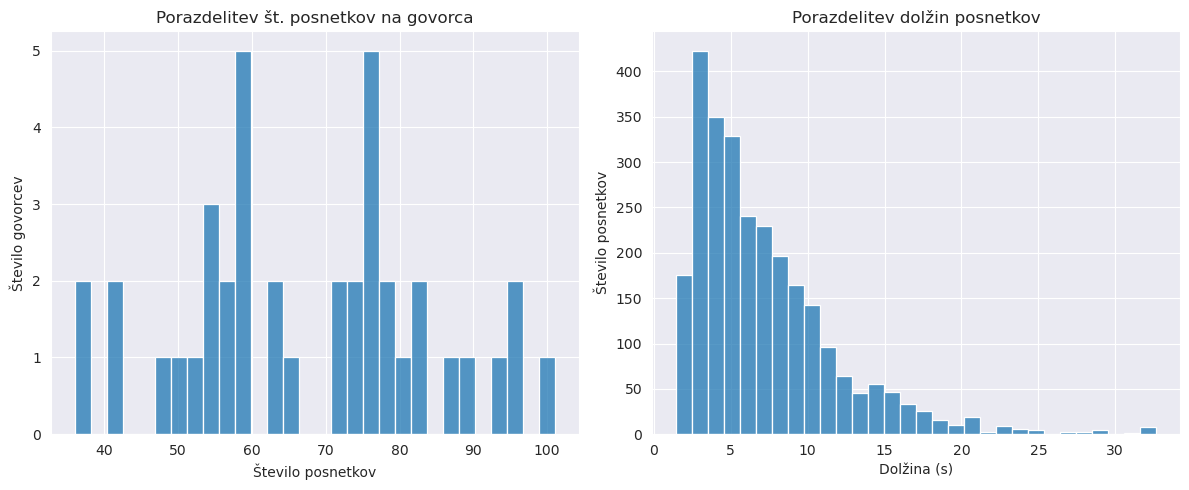

In [4]:
analyze_dataset()

In [5]:
def load_data_from_h5(feature_model_path):
    if not os.path.exists(feature_model_path):
        raise Exception(f"Datoteka {feature_model_path} ne obstaja")

    with h5py.File(feature_model_path, 'r') as hf:
        X = np.array(hf.get('features'))
        y_str = np.array(hf.get('labels'))

    y_str = [label.decode('utf-8') for label in y_str]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_str)
    num_classes = len(label_encoder.classes_)
    y_categorical = to_categorical(y_encoded, num_classes=num_classes)

    X = X[..., np.newaxis]

    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    print(f"Velikost učne množice: {X_train.shape[0]}")
    print(f"Velikost validacijske množice: {X_val.shape[0]}")
    print(f"Velikost testne množice: {X_test.shape[0]}")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), label_encoder, num_classes

In [6]:
def process_and_save_features(num_speakers_to_process=100):
    path = os.path.join(DATA_DIR, f"speaker_data_{num_speakers_to_process}.h5")
    if os.path.exists(path):
        return

    features = []
    labels = []

    all_speaker_dirs = sorted([d for d in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, d))])
    speakers_to_process = all_speaker_dirs[:num_speakers_to_process]
    print(f"Obdelujem {len(speakers_to_process)} govorcev...")

    segment_len_samples = int(SEGMENT_LEN_S * SAMPLE_RATE)
    max_len_samples = int(MAX_AUDIO_LEN_S * SAMPLE_RATE)

    for speaker_id in speakers_to_process:
        speaker_path = os.path.join(EXTRACT_PATH, speaker_id)
        print(f"Obdelujem govorca: {speaker_id}")
        for root, _, files in os.walk(speaker_path):
            for f in files:
                if not f.endswith(".flac"):
                    continue

                file_path = os.path.join(root, f)
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                if len(y) > max_len_samples:
                    y = y[:max_len_samples]

                for start in range(0, len(y) - segment_len_samples + 1, segment_len_samples):
                    segment = y[start:start + segment_len_samples]
                    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                    features.append(mfcc)
                    labels.append(speaker_id)

    with h5py.File(path, 'w') as hf:
        hf.create_dataset('features', data=np.array(features, dtype=np.float32))
        labels_ascii = [n.encode("ascii", "ignore") for n in labels]
        hf.create_dataset('labels', data=np.array(labels_ascii))

    print(f"Končano. Shranjenih {len(features)} vzorcev.")

In [7]:
def plot_history(history, title_suffix=""):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"Metrike učenja - {title_suffix}", fontsize=16)

    axs[0].plot(history.history['accuracy'], label='Učna natančnost')
    axs[0].plot(history.history['val_accuracy'], label='Validacijska natančnost')
    axs[0].set_ylabel('Natančnost')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Natančnost med učenjem')

    axs[1].plot(history.history['loss'], label='Učna izguba')
    axs[1].plot(history.history['val_loss'], label='Validacijska izguba')
    axs[1].set_xlabel('Epohe')
    axs[1].set_ylabel('Izguba')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Izguba med učenjem')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [8]:
def add_noise(data, snr_db):
    data_noisy = np.copy(data)
    for i in range(len(data_noisy)):
        signal = data_noisy[i]
        signal_power = np.mean(signal ** 2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
        data_noisy[i] = signal + noise
    return data_noisy

In [9]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/cuda/"


def create_model(input_shape, num_classes, layers_config='base', size_config='base'):
    if size_config == 'smaller':
        filters = [16, 32, 64]  # Added a third filter size for the deep config
        dense_units = 64
    elif size_config == 'larger':
        filters = [64, 128, 256]
        dense_units = 256
    else: # 'base'
        filters = [32, 64, 128]
        dense_units = 128

    # Use l2 regularization if weight_decay is greater than 0
    kernel_regularizer = l2(0.001)

    model = Sequential()

    # --- Input Block ---
    model.add(Conv2D(filters[0], (3, 3), padding='same', kernel_regularizer=kernel_regularizer, input_shape=input_shape))
    # IMPROVEMENT: Added Batch Normalization before activation
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    # --- Hidden Block 1 ---
    model.add(Conv2D(filters[1], (3, 3), padding='same', kernel_regularizer=kernel_regularizer))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    # --- Optional Deep Block ---
    if layers_config == 'deep':
        # IMPROVEMENT: This layer now scales with size_config instead of being hardcoded
        model.add(Conv2D(filters[2], (3, 3), padding='same', kernel_regularizer=kernel_regularizer))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D((2, 2)))

    # --- Classifier Head ---
    model.add(Flatten())

    model.add(Dense(dense_units, kernel_regularizer=kernel_regularizer))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    # IMPROVEMENT: Dropout rate is now a parameter
    model.add(Dropout(0.5))

    # --- Output Layer ---
    # No activation here, as it will be handled by the loss function (from_logits=True)
    # for better numerical stability. Or use softmax as before. Softmax is fine.
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

2025-07-06 20:02:08.706658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751824928.723233  236853 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751824928.727912  236853 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def run_experiment(exp_title, model_config, noise_snr=None, feature_model_path=''):
    print(f"\n{'=' * 20} ZAČETEK EKSPERIMENTA: {exp_title} {'=' * 20}")

    (X_train, y_train), (X_val, y_val), (X_test, y_test), le, num_classes = load_data_from_h5(feature_model_path)
    if X_train is None:
        return
    input_shape = X_train.shape[1:]
    model_path = f'best_model_{exp_title}.h5'
    history = None  # So we can later check if model was trained now or loaded

    if not os.path.exists(model_path):
        print("Model ne obstaja, začnem učenje...")
        model = create_model(input_shape, num_classes, **model_config)
        print("\n--- Arhitektura modela ---")
        model.summary()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        start_time = time.time()
        batch_size = 8 if model_config['layers_config'] == 'deep' or model_config['size_config'] == 'larger'  else 64

        history = model.fit(X_train, y_train,
                            epochs=100,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)
        training_time = time.time() - start_time
        print(f"\nČas učenja: {training_time:.2f} sekund ({training_time / 60:.2f} minut)")
        model.save(model_path)
    else:
        print(f"Model že obstaja: {model_path}, nalagam ga...")

    best_model = load_model(model_path)

    # Priprava testnih podatkov (z morebitnim šumom)
    eval_X_test = X_test
    if noise_snr is not None:
        print(f"Dodajam šum na testno množico: SNR = {noise_snr} dB")
        eval_X_test = add_noise(X_test, noise_snr)

    test_loss, test_acc = best_model.evaluate(eval_X_test, y_test, verbose=0)
    print(f"\nRezultati na testni množici ({exp_title}):")
    print(f"  - Izguba: {test_loss:.4f}")
    print(f"  - Natančnost: {test_acc * 100:.2f}%")

    if history is not None:
        plot_history(history, exp_title)
    else:
        print("Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.")

    predictions = best_model.predict(eval_X_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(12, 10))
    num_to_display = min(num_classes, 15)
    sns.heatmap(conf_matrix[:num_to_display, :num_to_display], annot=True, fmt='d',
                xticklabels=le.classes_[:num_to_display], yticklabels=le.classes_[:num_to_display])
    plt.title(f'Matrika zamešitev - {exp_title} (prvih {num_to_display} govorcev)')
    plt.xlabel('Predviden razred')
    plt.ylabel('Dejanski razred')
    plt.show()

In [11]:
N_SPEAKERS = 50
feature_model_path = os.path.join(DATA_DIR, f"speaker_data_{N_SPEAKERS}.h5")
process_and_save_features(num_speakers_to_process=N_SPEAKERS)

### Vpliv števila plasti


==================== ZAČETEK EKSPERIMENTA: A1_Plasti_Simple ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751824930.783687  236853 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8391 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



--- Arhitektura modela ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,800 (4.78 MB)

 Trainable params: 1,253,352 (4.78 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100


I0000 00:00:1751824933.623066  236930 service.cc:148] XLA service 0x7fcdb40045c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751824933.623084  236930 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-07-06 20:02:13.676937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751824933.858614  236930 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-07-06 20:02:14.179299: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_confi

35/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1729 - loss: 3.6067

I0000 00:00:1751824935.960424  236930 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2938 - loss: 3.1179

2025-07-06 20:02:16.804887: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[60,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[60,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3116 - loss: 3.0521

2025-07-06 20:02:19.802429: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[22,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.3140 - loss: 3.0432 - val_accuracy: 0.0847 - val_loss: 7.2681
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8903 - loss: 1.0837 - val_accuracy: 0.7477 - val_loss: 1.4553
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9711 - loss: 0.6573 - val_accuracy: 0.8811 - val_loss: 0.9983
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9877 - loss: 0.4886 - val_accuracy: 0.8982 - val_loss: 0.7673
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9909 - loss: 0.3980 - val_accuracy: 0.9252 - val_loss: 0.6247
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9934 - loss: 0.3356 - val_accuracy: 0.8802 - val_loss: 0.7179
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9961 - loss: 0.2929 - val_accuracy: 0.8946 - val_loss: 0.6194
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9933 - loss: 0.2811 - val_accuracy: 0.8631 - val_loss: 0.


Čas učenja: 26.93 sekund (0.45 minut)


2025-07-06 20:02:39.107031: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}



Rezultati na testni množici (A1_Plasti_Simple):
  - Izguba: 0.3697
  - Natančnost: 95.95%


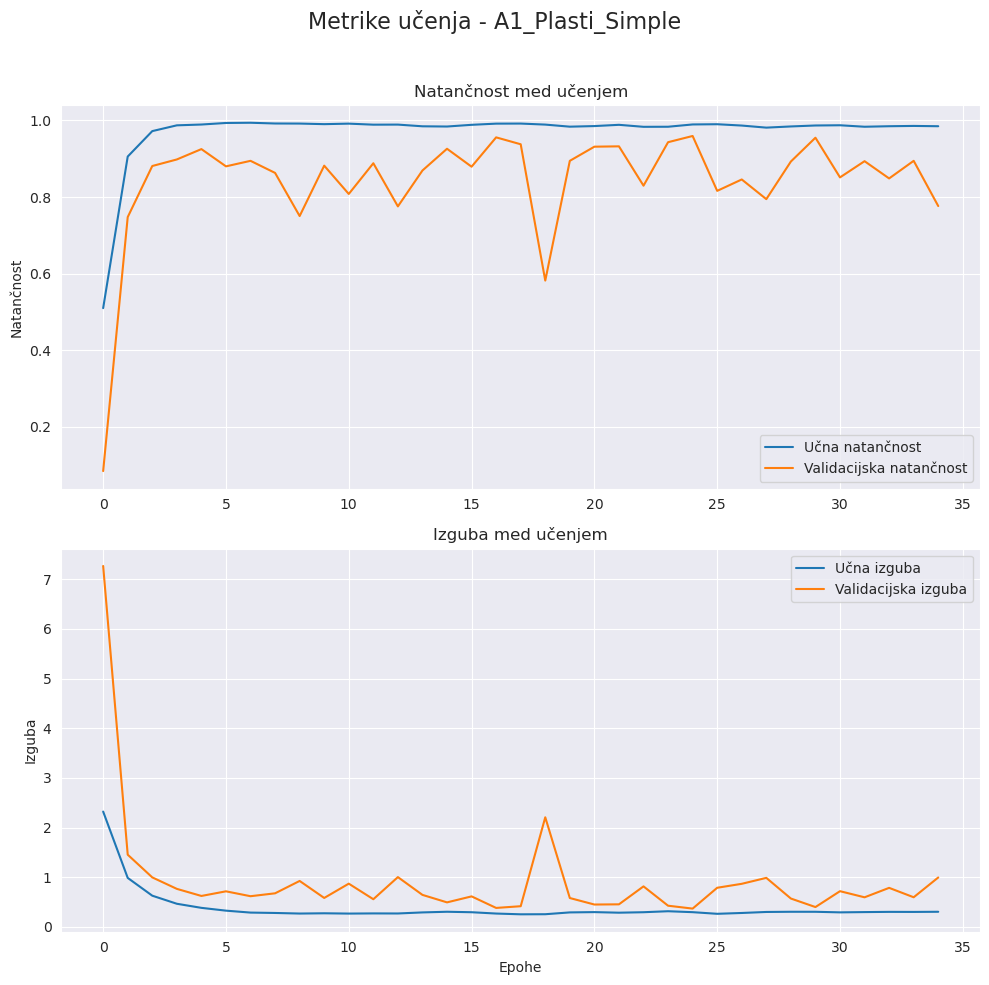

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


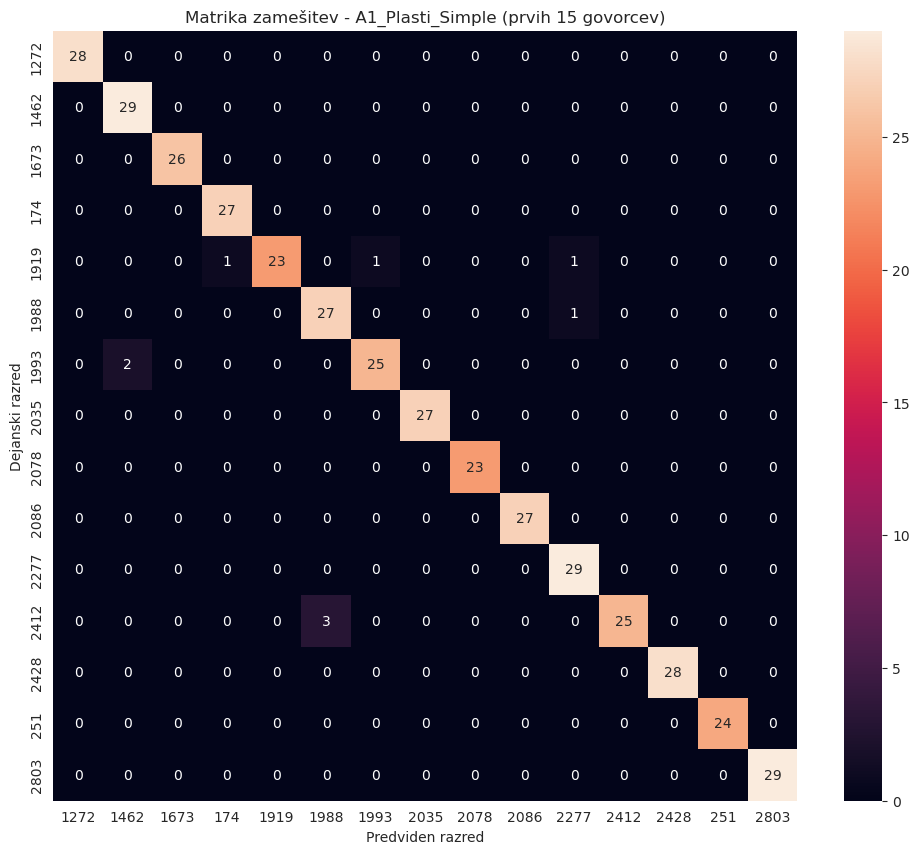


==================== ZAČETEK EKSPERIMENTA: A2_Plasti_Base ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...

--- Arhitektura modela ---


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,800 (4.78 MB)

 Trainable params: 1,253,352 (4.78 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3222 - loss: 3.0374 - val_accuracy: 0.0288 - val_loss: 10.2790
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8795 - loss: 1.1040 - val_accuracy: 0.6351 - val_loss: 1.6192
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9674 - loss: 0.6530 - val_accuracy: 0.9171 - val_loss: 0.8959
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9852 - loss: 0.4787 - val_accuracy: 0.9153 - val_loss: 0.7439
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9855 - loss: 0.3983 - val_accuracy: 0.9730 - val_loss: 0.4944
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9916 - loss: 0.3435 - val_accuracy: 0.9180 - val_loss: 0.5882
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.3025 - val_accuracy: 0.9423 - val_loss: 0.5147
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9931 - loss: 0.2804 - val_accuracy: 0.9712 -


Čas učenja: 16.73 sekund (0.28 minut)



Rezultati na testni množici (A2_Plasti_Base):
  - Izguba: 0.3703
  - Natančnost: 96.58%


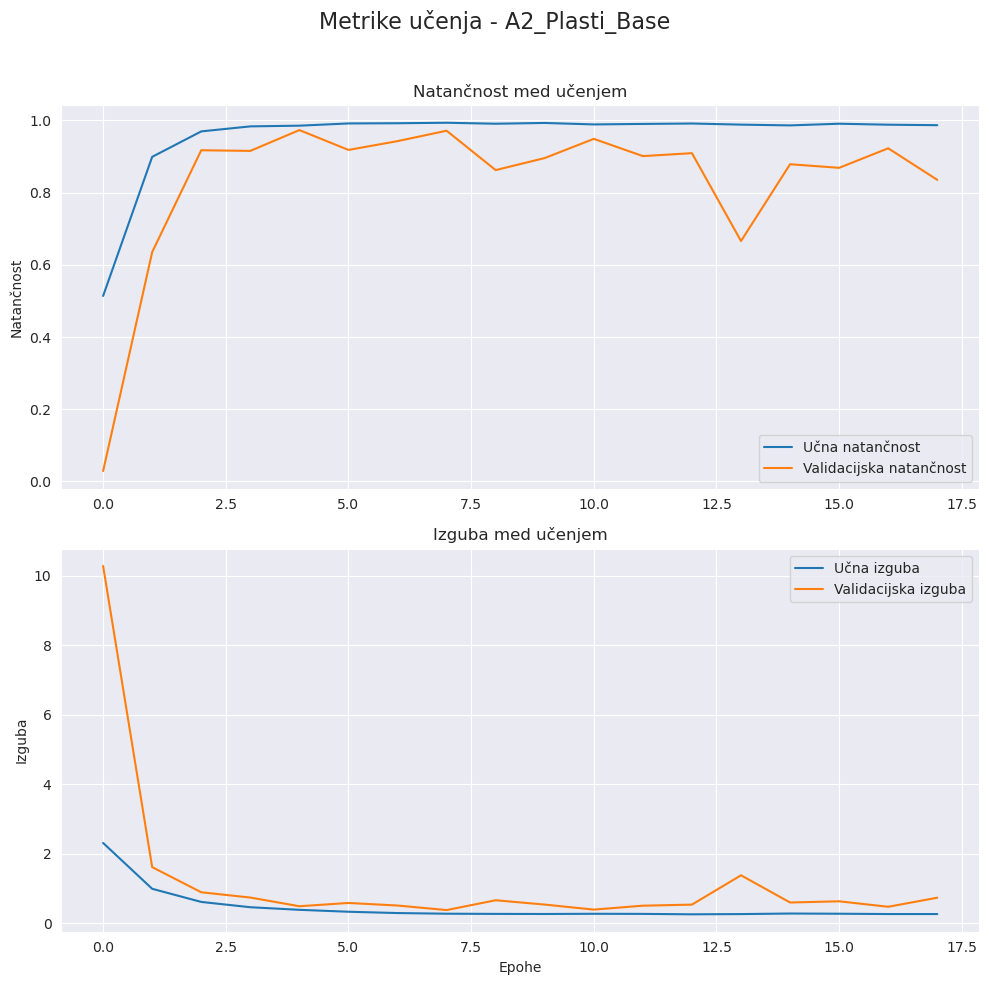

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


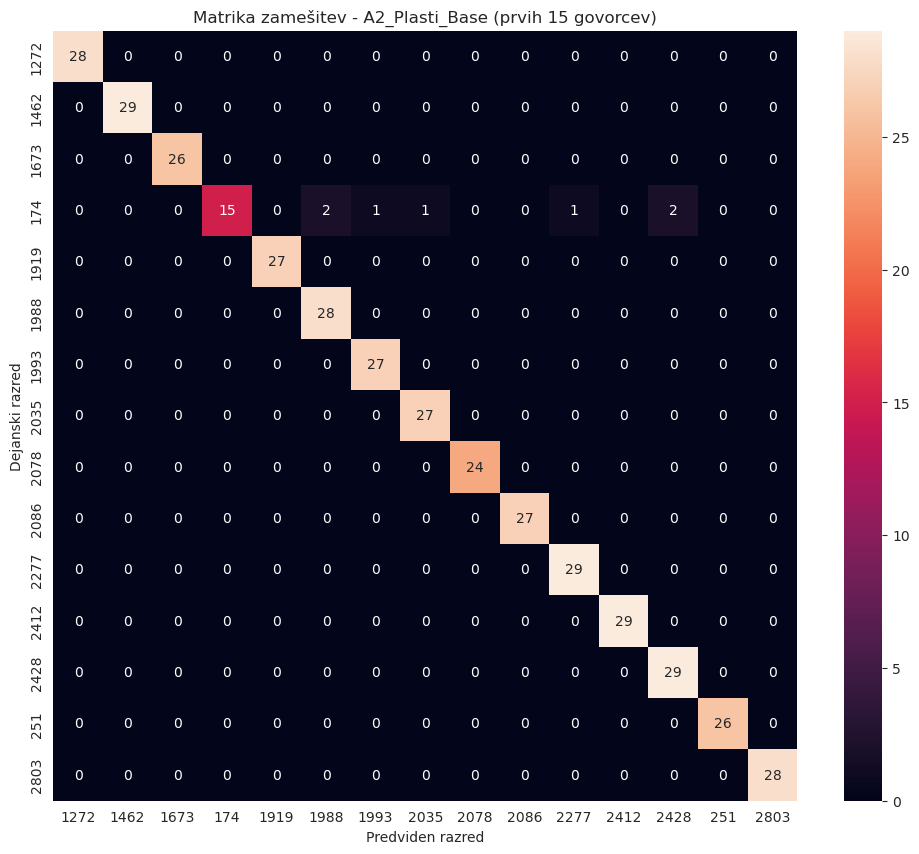


==================== ZAČETEK EKSPERIMENTA: A3_Plasti_Deep ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...

--- Arhitektura modela ---


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       573,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 672,808 (2.57 MB)

 Trainable params: 672,104 (2.56 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/100


2025-07-06 20:03:05.656666: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 20:03:05.680633: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,128,10,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,10,15]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", 

643/648 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3128 - loss: 3.0923

2025-07-06 20:03:10.389942: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 20:03:10.419993: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,128,10,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,10,15]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", 

648/648 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3141 - loss: 3.0869

2025-07-06 20:03:13.885015: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[6,64,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,32,20,31]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 20:03:13.912661: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[6,128,10,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,64,10,15]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", 

648/648 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.3144 - loss: 3.0858 - val_accuracy: 0.7793 - val_loss: 1.3358
Epoch 2/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7776 - loss: 1.3463 - val_accuracy: 0.9486 - val_loss: 0.8100
Epoch 3/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8516 - loss: 1.0640 - val_accuracy: 0.8315 - val_loss: 1.1020
Epoch 4/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8902 - loss: 0.9321 - val_accuracy: 0.9000 - val_loss: 0.8732
Epoch 5/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8976 - loss: 0.8963 - val_accuracy: 0.8568 - val_loss: 1.0536
Epoch 6/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8984 - loss: 0.9097 - val_accuracy: 0.6225 - val_loss: 2.1846
Epoch 7/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9098 - loss: 0.9137 - val_accuracy: 0.8045 - val_loss: 1.3004
Epoch 8/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8974 - loss: 0.9181 - val_accuracy: 0.96


Čas učenja: 101.66 sekund (1.69 minut)


2025-07-06 20:04:45.335487: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,128,10,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,10,15]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 20:04:45.967194: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[22,128,10,15]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,64,10,15]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor


Rezultati na testni množici (A3_Plasti_Deep):
  - Izguba: 0.5527
  - Natančnost: 98.20%


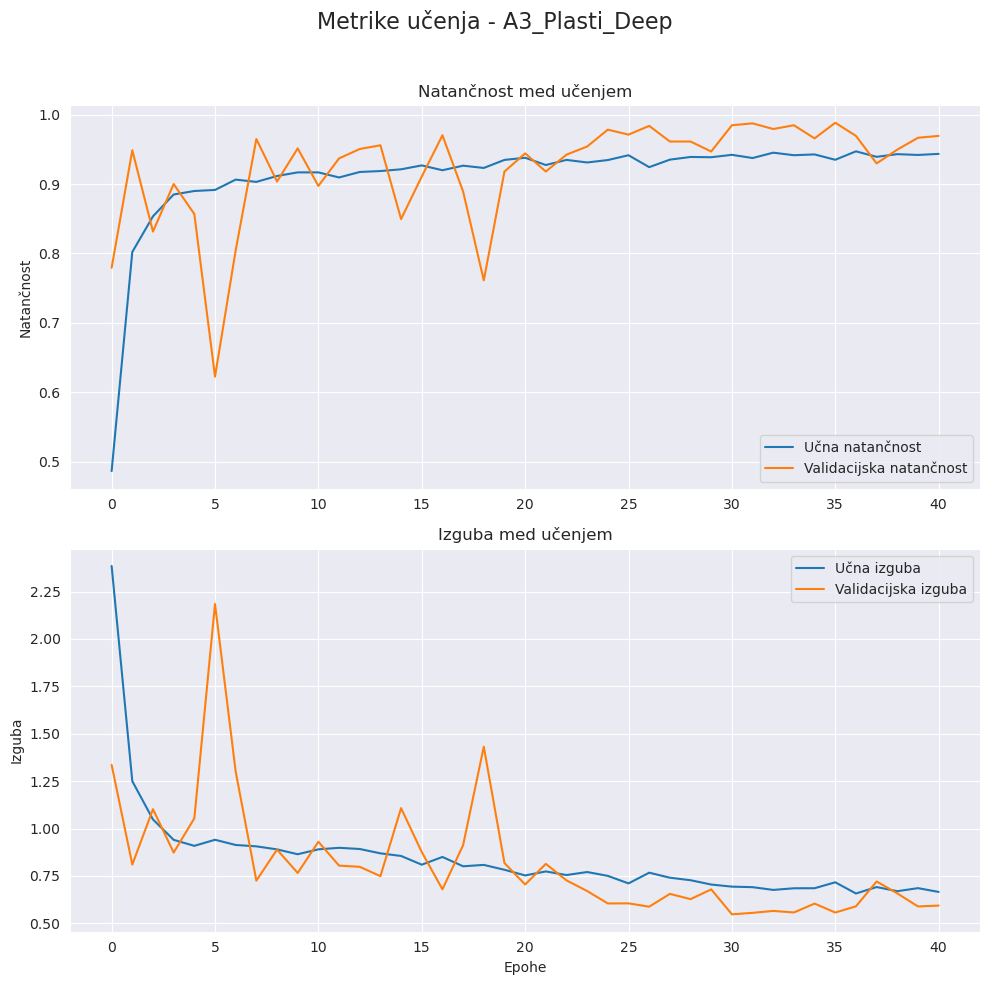

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


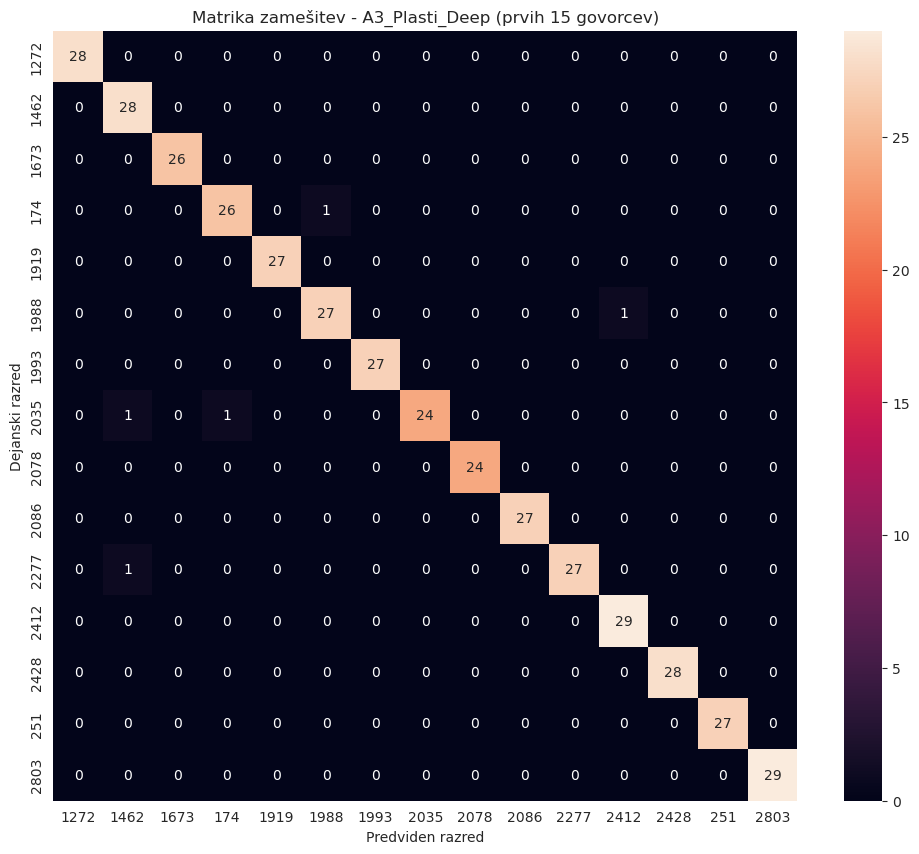

In [12]:
run_experiment("A1_Plasti_Simple", model_config={'layers_config': 'simple', 'size_config': 'base'}, feature_model_path=feature_model_path)
run_experiment("A2_Plasti_Base", model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)
run_experiment("A3_Plasti_Deep", model_config={'layers_config': 'deep', 'size_config': 'base'}, feature_model_path=feature_model_path)

### Vpliv velikosti plasti (na najboljši arhitekturi iz koraka A)


==================== ZAČETEK EKSPERIMENTA: B1_Velikost_Smaller ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...

--- Arhitektura modela ---


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 40, 63, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 40, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 40, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 31, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 20, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       307,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,112 (1.20 MB)

 Trainable params: 314,888 (1.20 MB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/100


2025-07-06 20:05:32.424179: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,32,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,16,20,31]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1702 - loss: 3.4153

2025-07-06 20:05:35.020238: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[60,32,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[60,16,20,31]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1734 - loss: 3.4027

2025-07-06 20:05:37.457244: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[22,32,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,16,20,31]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.1749 - loss: 3.3966 - val_accuracy: 0.1658 - val_loss: 4.8447
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6221 - loss: 1.8942 - val_accuracy: 0.3604 - val_loss: 2.2393
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7916 - loss: 1.2801 - val_accuracy: 0.7730 - val_loss: 1.3093
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8776 - loss: 0.9294 - val_accuracy: 0.8486 - val_loss: 0.9947
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9091 - loss: 0.7037 - val_accuracy: 0.8811 - val_loss: 0.8172
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9320 - loss: 0.5939 - val_accuracy: 0.9405 - val_loss: 0.5485
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9492 - loss: 0.5013 - val_accuracy: 0.9532 - val_loss: 0.4925
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9492 - loss: 0.4566 - val_accuracy: 0.9586 - val_loss: 0.


Čas učenja: 19.68 sekund (0.33 minut)


2025-07-06 20:05:49.952973: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,32,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,20,31]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}



Rezultati na testni množici (B1_Velikost_Smaller):
  - Izguba: 0.2878
  - Natančnost: 96.76%


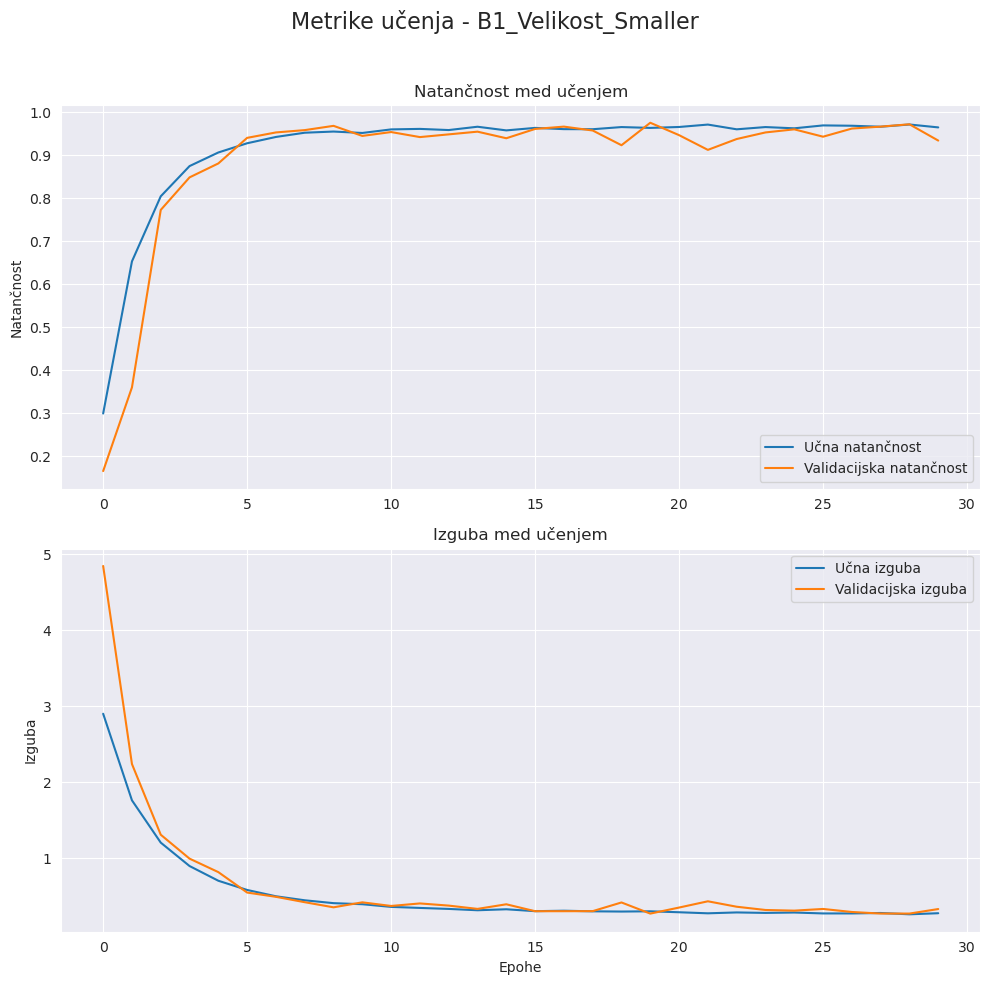

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


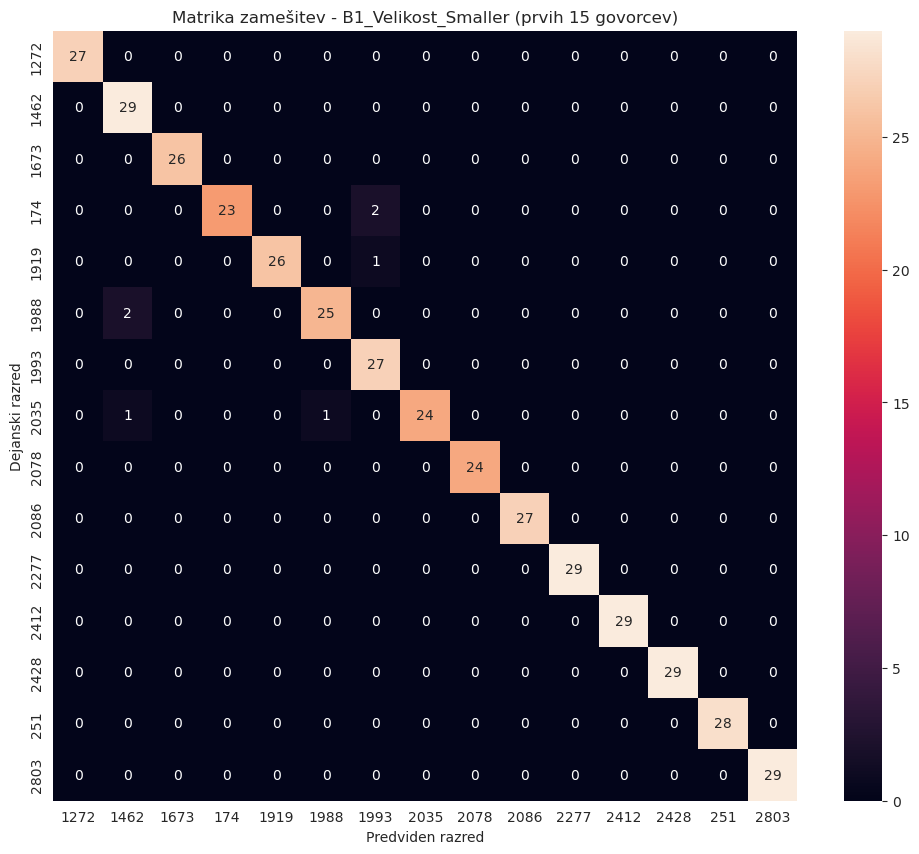


==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...

--- Arhitektura modela ---


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,800 (4.78 MB)

 Trainable params: 1,253,352 (4.78 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3120 - loss: 3.0360 - val_accuracy: 0.1396 - val_loss: 5.8967
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8856 - loss: 1.0804 - val_accuracy: 0.7162 - val_loss: 1.3201
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9703 - loss: 0.6421 - val_accuracy: 0.8640 - val_loss: 0.9199
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9873 - loss: 0.4864 - val_accuracy: 0.9360 - val_loss: 0.6112
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9921 - loss: 0.3908 - val_accuracy: 0.7982 - val_loss: 0.9090
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9928 - loss: 0.3350 - val_accuracy: 0.9261 - val_loss: 0.5401
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.2960 - val_accuracy: 0.9550 - val_loss: 0.4313
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9959 - loss: 0.2691 - val_accuracy: 0.9153 - 


Čas učenja: 15.79 sekund (0.26 minut)



Rezultati na testni množici (B2_Velikost_Base):
  - Izguba: 0.4116
  - Natančnost: 96.40%


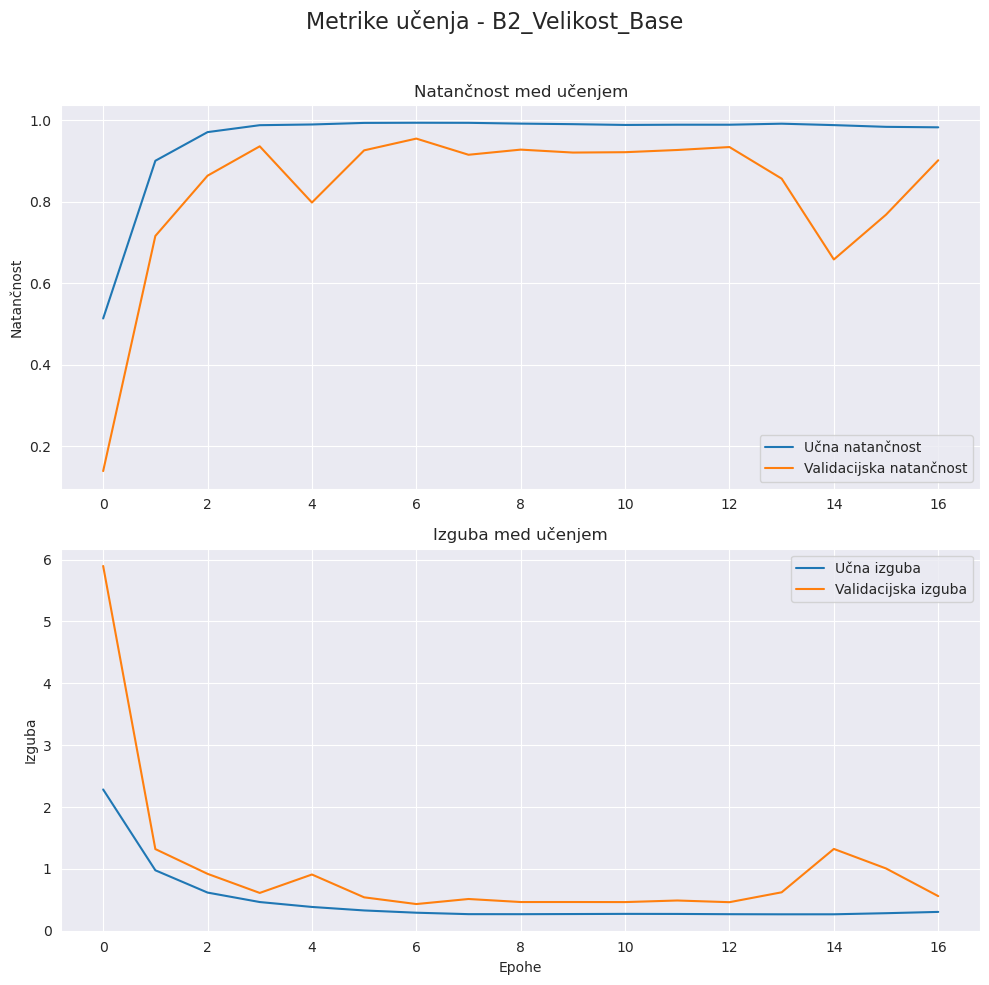

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


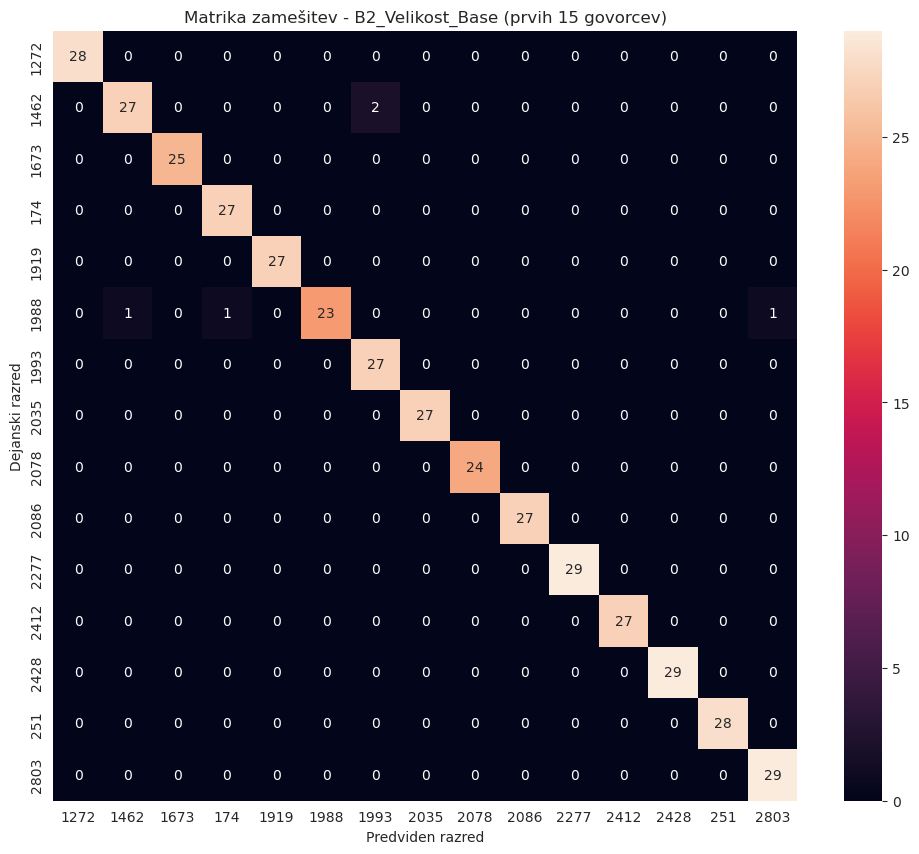


==================== ZAČETEK EKSPERIMENTA: B3_Velikost_Larger ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...

--- Arhitektura modela ---


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 40, 63, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 40, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 40, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 20, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 20, 31, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 20, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     4,915,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,002,024 (19.08 MB)

 Trainable params: 5,001,128 (19.08 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100


2025-07-06 20:06:14.341016: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[8,128,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,20,31]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


640/648 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4449 - loss: 3.0000

2025-07-06 20:06:19.387000: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,128,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,20,31]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


648/648 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4473 - loss: 2.9912

2025-07-06 20:06:22.730281: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[6,128,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,64,20,31]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


648/648 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4476 - loss: 2.9901 - val_accuracy: 0.7252 - val_loss: 1.8305
Epoch 2/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8814 - loss: 1.4676 - val_accuracy: 0.8568 - val_loss: 1.5047
Epoch 3/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9040 - loss: 1.3796 - val_accuracy: 0.8090 - val_loss: 1.8284
Epoch 4/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9123 - loss: 1.4374 - val_accuracy: 0.6559 - val_loss: 2.2743
Epoch 5/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9091 - loss: 1.4552 - val_accuracy: 0.8766 - val_loss: 1.6483
Epoch 6/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9097 - loss: 1.4979 - val_accuracy: 0.7631 - val_loss: 1.9652
Epoch 7/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9190 - loss: 1.4523 - val_accuracy: 0.8982 - val_loss: 1.5033
Epoch 8/100
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9195 - loss: 1.4037 - val_accuracy: 0.81


Čas učenja: 164.97 sekund (2.75 minut)


2025-07-06 20:08:57.743620: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,128,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,20,31]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-06 20:08:58.403067: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[22,128,20,31]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,64,20,31]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor


Rezultati na testni množici (B3_Velikost_Larger):
  - Izguba: 0.8180
  - Natančnost: 98.47%


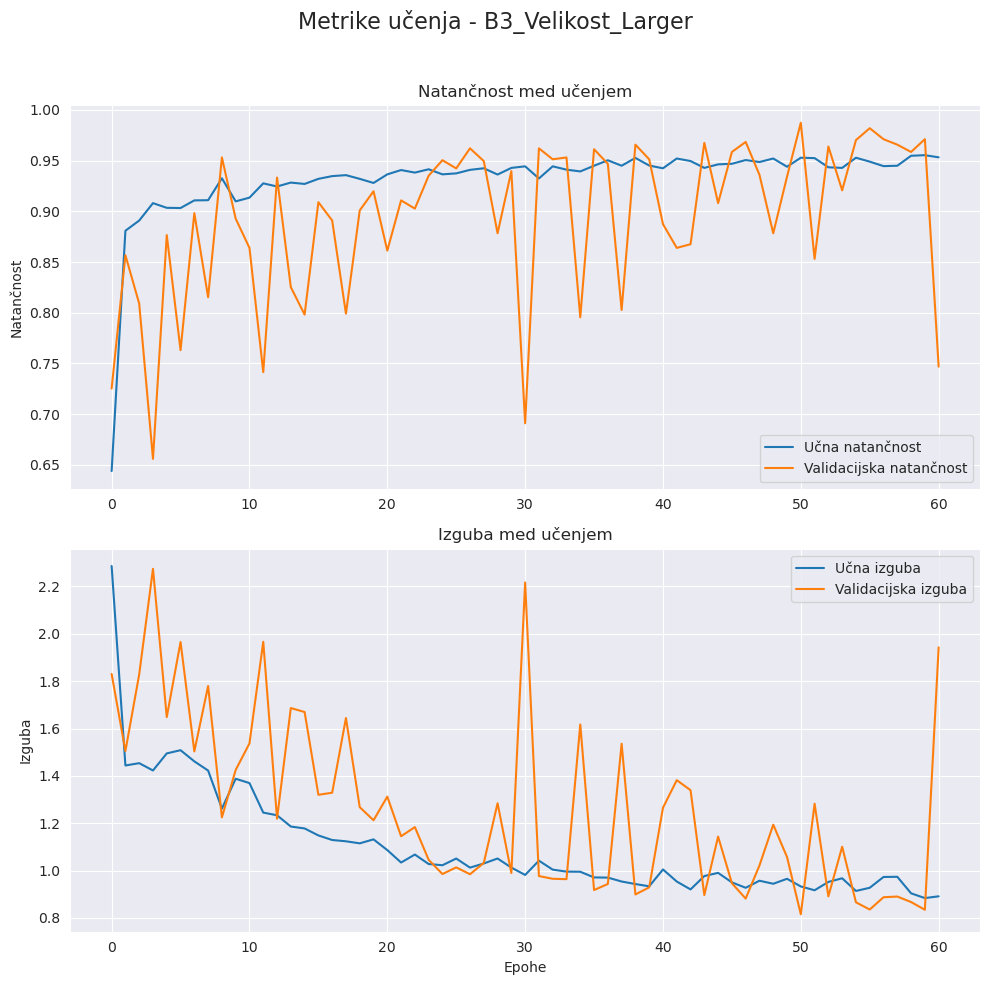

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


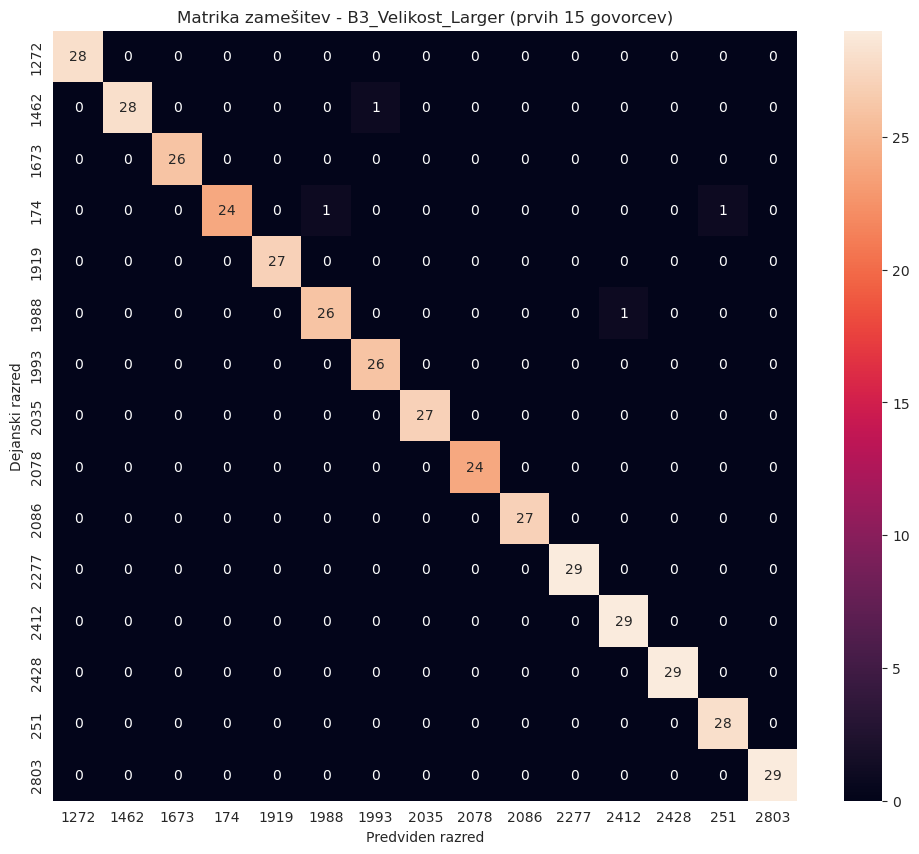

In [13]:
run_experiment("B1_Velikost_Smaller", model_config={'layers_config': 'base', 'size_config': 'smaller'}, feature_model_path=feature_model_path)
run_experiment("B2_Velikost_Base", model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)
run_experiment("B3_Velikost_Larger", model_config={'layers_config': 'base', 'size_config': 'larger'}, feature_model_path=feature_model_path)

### Vpliv šuma (na najboljšem modelu iz koraka B)


==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base ====================


Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model že obstaja: best_model_B2_Velikost_Base.h5, nalagam ga...

Rezultati na testni množici (B2_Velikost_Base):
  - Izguba: 0.4116
  - Natančnost: 96.40%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


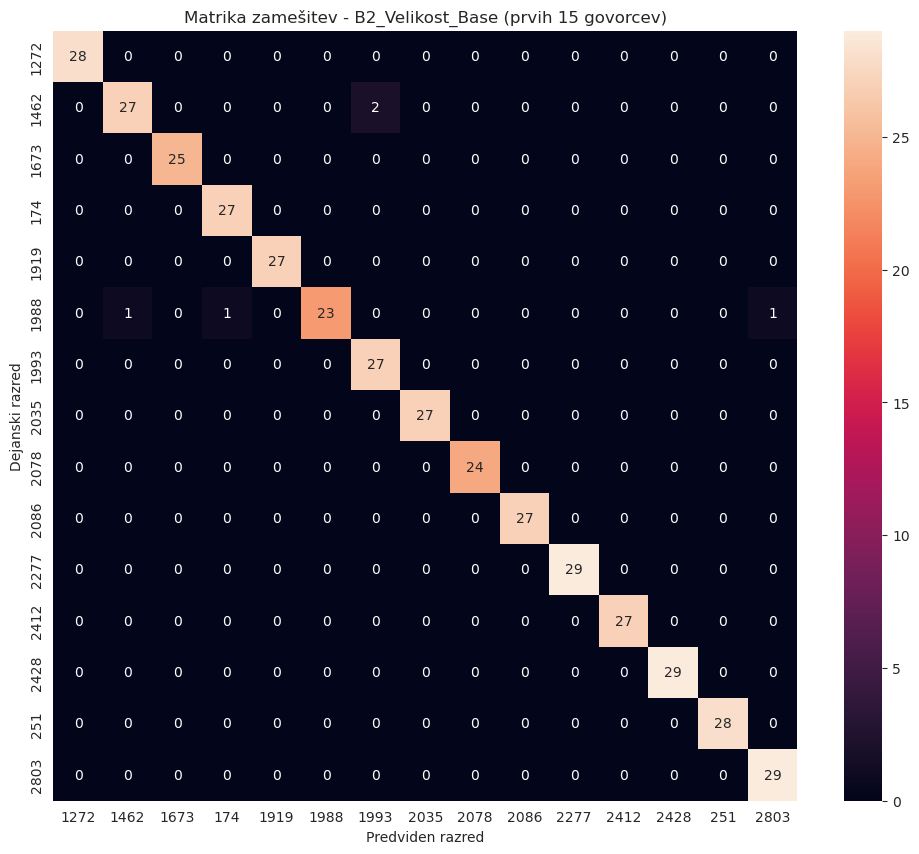


==================== ZAČETEK EKSPERIMENTA: C4_Sum_SNR0 ====================
Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model ne obstaja, začnem učenje...

--- Arhitektura modela ---


/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,800 (4.78 MB)

 Trainable params: 1,253,352 (4.78 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3217 - loss: 3.0156 - val_accuracy: 0.1865 - val_loss: 4.7534
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8767 - loss: 1.0936 - val_accuracy: 0.6919 - val_loss: 1.4509
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9646 - loss: 0.6626 - val_accuracy: 0.8243 - val_loss: 1.0905
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9850 - loss: 0.4911 - val_accuracy: 0.9252 - val_loss: 0.6737
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9923 - loss: 0.4010 - val_accuracy: 0.8739 - val_loss: 0.7137
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.3299 - val_accuracy: 0.9459 - val_loss: 0.4958
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9931 - loss: 0.3078 - val_accuracy: 0.9009 - val_loss: 0.5498
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 - loss: 0.2853 - val_accuracy: 0.9090 - 


Čas učenja: 17.50 sekund (0.29 minut)


Dodajam šum na testno množico: SNR = 0 dB

Rezultati na testni množici (C4_Sum_SNR0):
  - Izguba: 46.4512
  - Natančnost: 2.61%


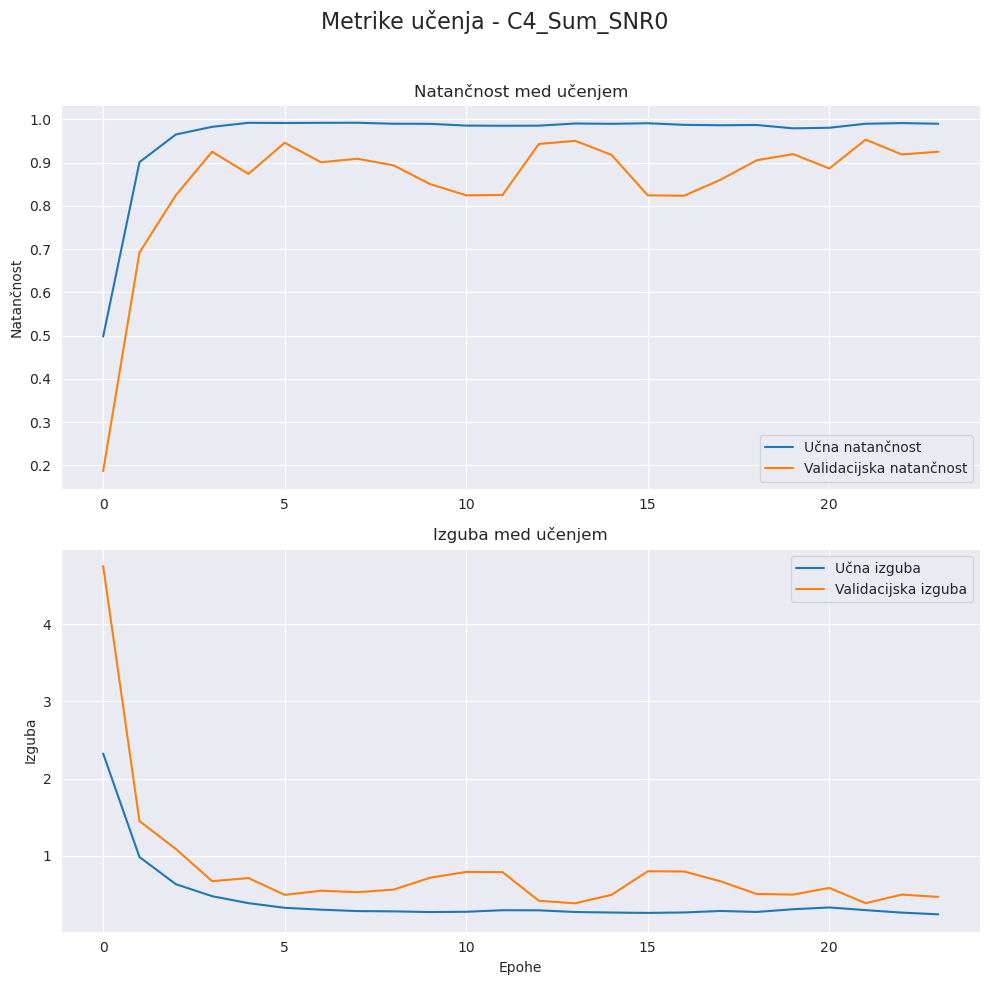

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


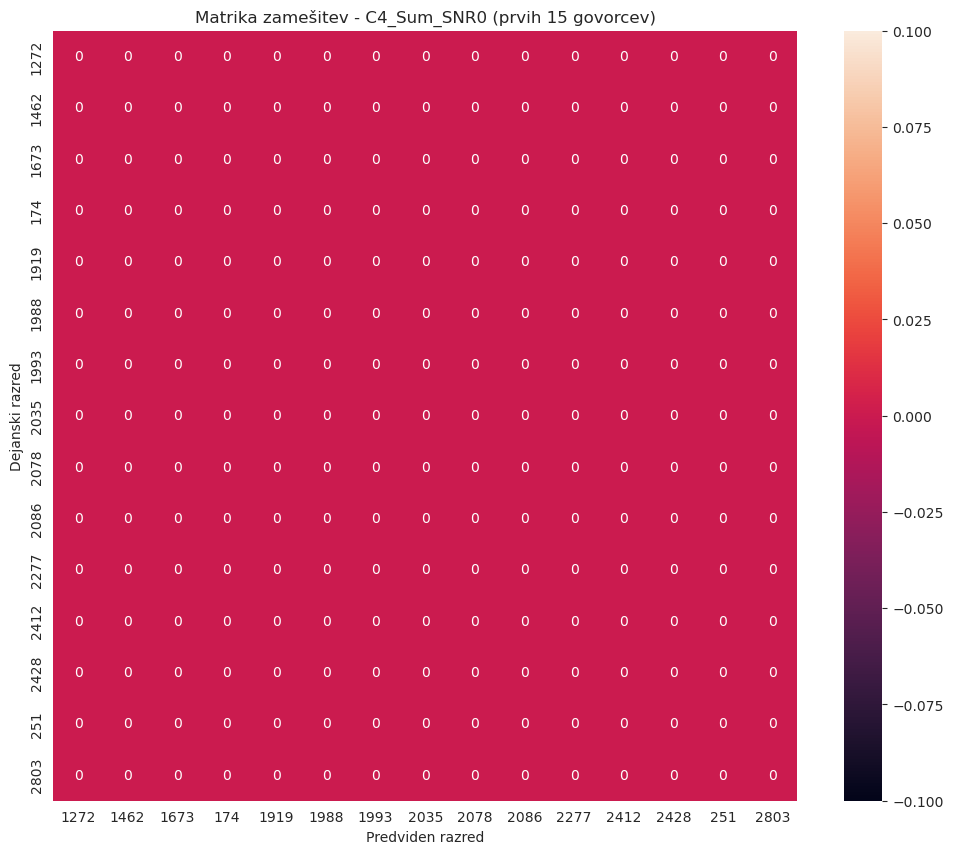

In [14]:
run_experiment("B2_Velikost_Base", model_config={'layers_config': 'base', 'size_config': 'base'}, noise_snr=None, feature_model_path=feature_model_path)
run_experiment("C4_Sum_SNR0", model_config={'layers_config': 'base', 'size_config': 'base'}, noise_snr=0, feature_model_path=feature_model_path)

### Vpliv števila govorcev

Analiza za 50 govorcev

==================== ZAČETEK EKSPERIMENTA: B2_Velikost_Base ====================


Velikost učne množice: 5180
Velikost validacijske množice: 1110
Velikost testne množice: 1110
Model že obstaja: best_model_B2_Velikost_Base.h5, nalagam ga...

Rezultati na testni množici (B2_Velikost_Base):
  - Izguba: 0.4116
  - Natančnost: 96.40%
Trening ni bil izveden v tem zagonu, zato ni prikaza zgodovine učenja.
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


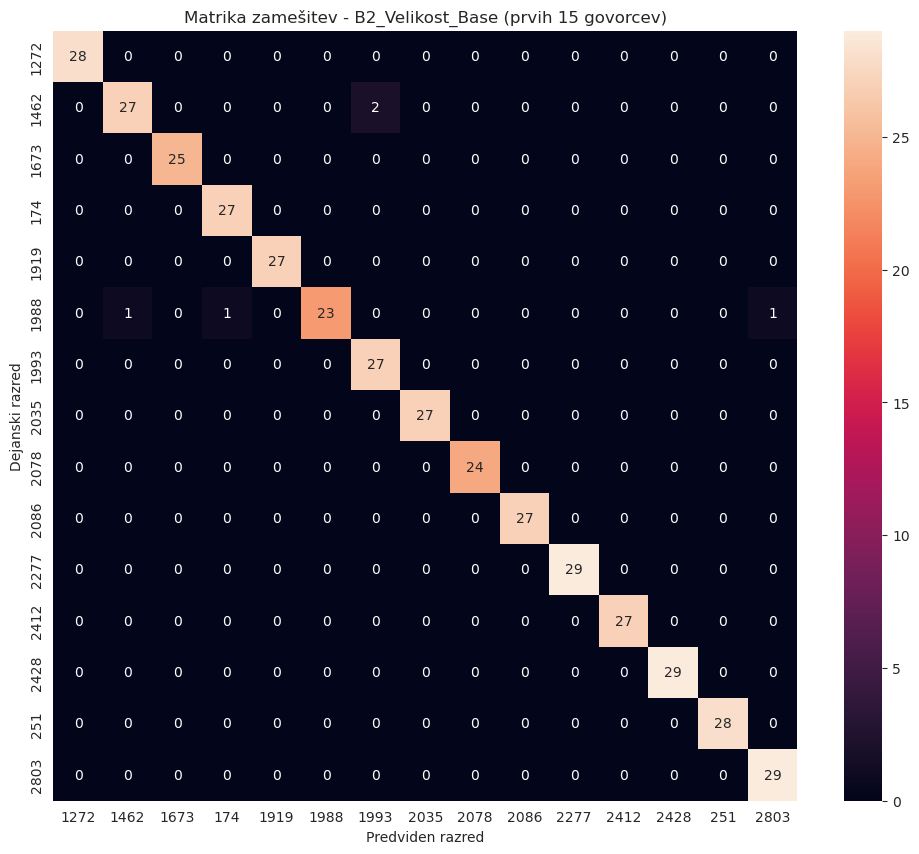

In [15]:
print("Analiza za 50 govorcev")
feature_model_path = os.path.join(DATA_DIR, f"speaker_data_50.h5")
process_and_save_features(num_speakers_to_process=50)
run_experiment('B2_Velikost_Base', model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)

Analiza za 100 govorcev
Obdelujem 40 govorcev...
Obdelujem govorca: 1272
Obdelujem govorca: 1462
Obdelujem govorca: 1673
Obdelujem govorca: 174
Obdelujem govorca: 1919
Obdelujem govorca: 1988
Obdelujem govorca: 1993
Obdelujem govorca: 2035
Obdelujem govorca: 2078
Obdelujem govorca: 2086
Obdelujem govorca: 2277
Obdelujem govorca: 2412
Obdelujem govorca: 2428
Obdelujem govorca: 251
Obdelujem govorca: 2803
Obdelujem govorca: 2902
Obdelujem govorca: 3000
Obdelujem govorca: 3081
Obdelujem govorca: 3170
Obdelujem govorca: 3536
Obdelujem govorca: 3576
Obdelujem govorca: 3752
Obdelujem govorca: 3853
Obdelujem govorca: 422
Obdelujem govorca: 5338
Obdelujem govorca: 5536
Obdelujem govorca: 5694
Obdelujem govorca: 5895
Obdelujem govorca: 6241
Obdelujem govorca: 6295
Obdelujem govorca: 6313
Obdelujem govorca: 6319
Obdelujem govorca: 6345
Obdelujem govorca: 652
Obdelujem govorca: 777
Obdelujem govorca: 7850
Obdelujem govorca: 7976
Obdelujem govorca: 8297
Obdelujem govorca: 84
Obdelujem govorca: 884

/home/aljaz/miniconda3/envs/07_mfcc_in_nm/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 40, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 20, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253,800 (4.78 MB)

 Trainable params: 1,253,352 (4.78 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2950 - loss: 3.1198 - val_accuracy: 0.2324 - val_loss: 4.6109
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8747 - loss: 1.1251 - val_accuracy: 0.7505 - val_loss: 1.3389
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9625 - loss: 0.6753 - val_accuracy: 0.9216 - val_loss: 0.8679
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9803 - loss: 0.5036 - val_accuracy: 0.8685 - val_loss: 0.8266
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9904 - loss: 0.4083 - val_accuracy: 0.8892 - val_loss: 0.7039
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9962 - loss: 0.3328 - val_accuracy: 0.9288 - val_loss: 0.5632
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.3010 - val_accuracy: 0.9333 - val_loss: 0.5237
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9884 - loss: 0.2972 - val_accuracy: 0.8550 - 


Čas učenja: 17.76 sekund (0.30 minut)



Rezultati na testni množici (B2_Velikost_Base_100):
  - Izguba: 0.3360
  - Natančnost: 96.67%


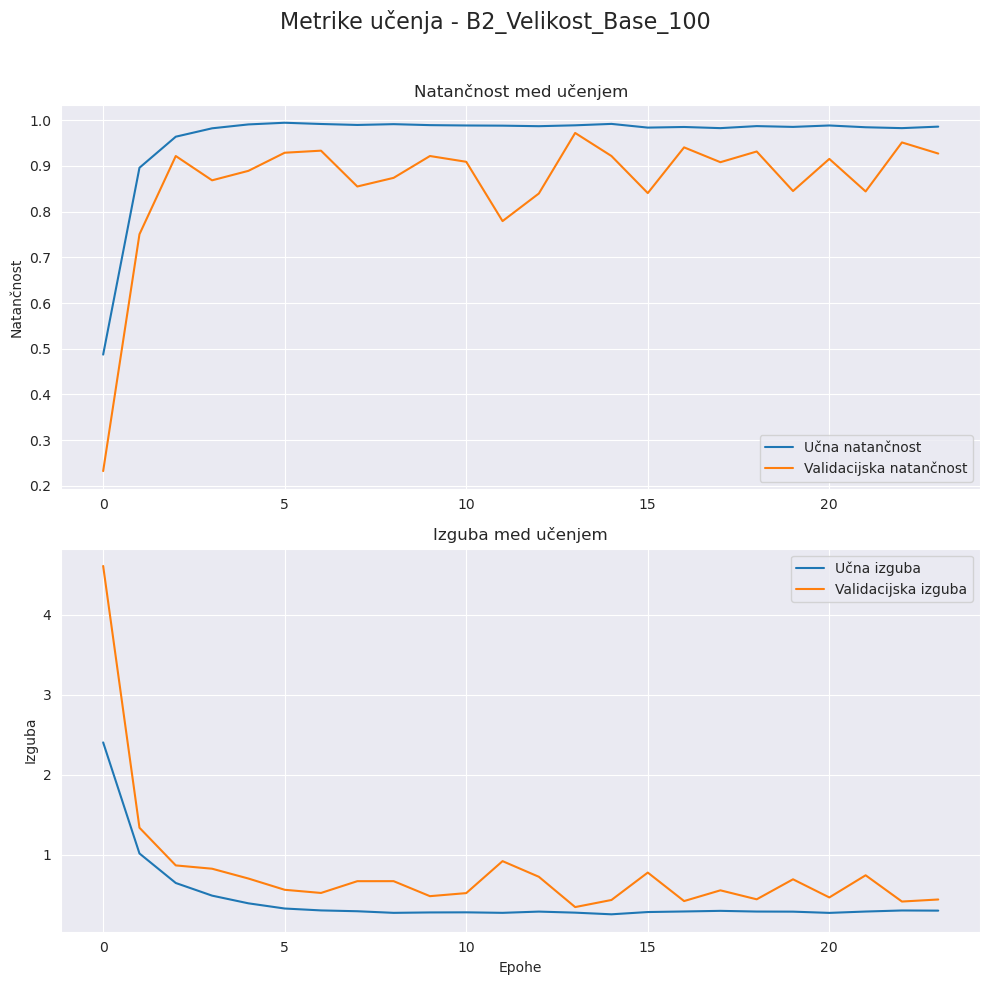

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


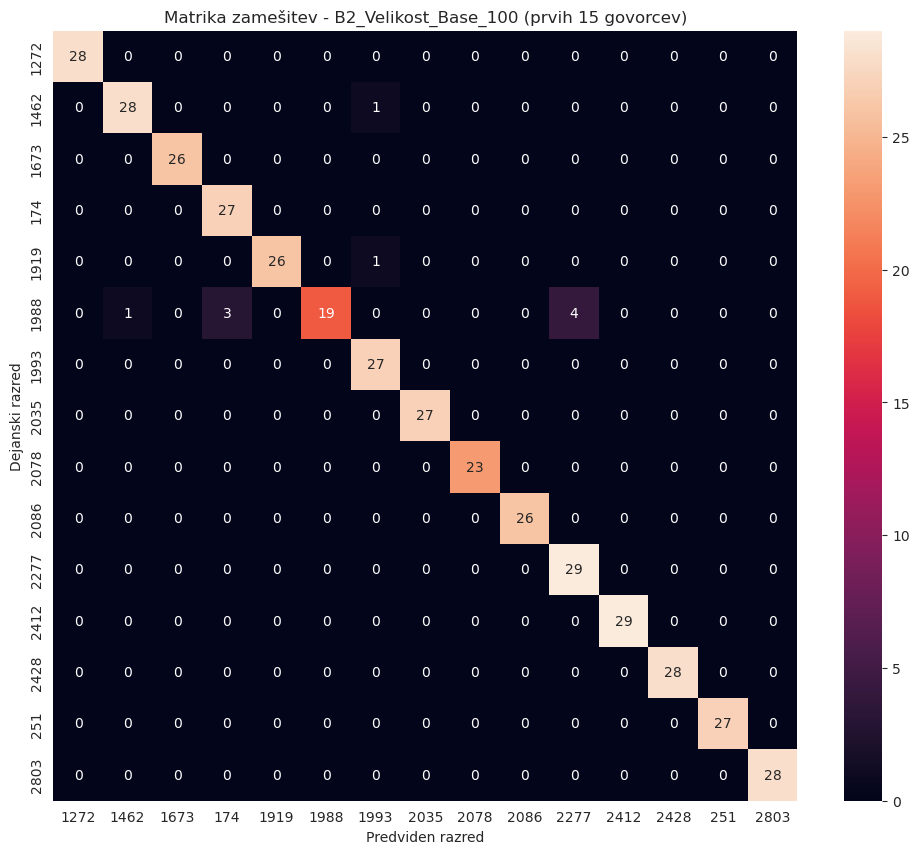

In [16]:
print("Analiza za 100 govorcev")
process_and_save_features(num_speakers_to_process=100)
feature_model_path = os.path.join(DATA_DIR, f"speaker_data_100.h5")
run_experiment('B2_Velikost_Base_100', model_config={'layers_config': 'base', 'size_config': 'base'}, feature_model_path=feature_model_path)